# **Εργασία 2 - Εντοπισμός Κοινοτήτων**

## Πρόβλημα 1: Μελέτη Πραγματικών Δικτύων
Θα εργαστείτε με τo σύνολο δεδομένων που αφορά σε ένα κατευθυνόμενο γράφο από
υπερσυνδέσμους μεταξύ blogs για τα πολιτικά των ΗΠΑ κατεγραμμένα το 2005 από τους Adamic and Glance. (L. A. Adamic and N. Glance, "The political blogosphere and the 2004 US Election", in Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005)) (http://www-personal.umich.edu/~mejn/netdata/polblogs.zip). Σε αυτό το σύνολο θεωρείστε ως ground-truth 2 κοινότητες που σηματοδοτούνται ως γνωρίσματα στους κόμβους (0 για τους φιλελεύθερους και 1 για
τους συντηρητικούς). 
Θα εφαρμόσετε και θα συγκρίνετε την απόδοση διαφορετικών τεχνικών εντοπισμού κοινοτήτων, σε σχέση με τις ground-truth κοινότητες που δίνονται. 
Επιλέξτε:
*   Μια μέθοδο βασισμένη στην εύρεση κλίκας 
*   Μια μέθοδο μεγιστοποίησης του modularity 
*   Μια συσσωρευτική ιεραρχική μέθοδο 
*   Μια διαιρετική ιεραρχική μέθοδο
*   Μια μέθοδο φασματικής ανάλυσης

Μετρήστε: 
1.   Ακρίβεια (precision)
2.   Ποσοστό Ανάκλησης (recall)
3.   Purity
4.   NMI
5.   modularity (και συγκρίνετε με το modularity των ground-truth κοινοτήτων)
6.   conductance (και συγκρίνετε με το conductance των ground-truth κοινοτήτων)
7.   density (και συγκρίνετε με το density των ground-truth κοινοτήτων)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from random import randint
import itertools as it
import pandas as pd



---


**Change directory here!**

---



In [4]:
# G1 = nx.read_gml("/content/drive/MyDrive/Colab Notebooks/AIDA/2ο Εξάμηνο/polblogs.gml")

In [ ]:
ground_truth = nx.get_node_attributes(G1, 'value')
ground_truth_items = sorted(ground_truth.items())
ground_truth_dict = dict(ground_truth)
comm_gt = {}
for i, j in sorted(ground_truth.items()):
    comm_gt.setdefault(j, []).append(i)
communities_gt = [set(x) for x in comm_gt.values()]

Plot 2 communities (initial network)

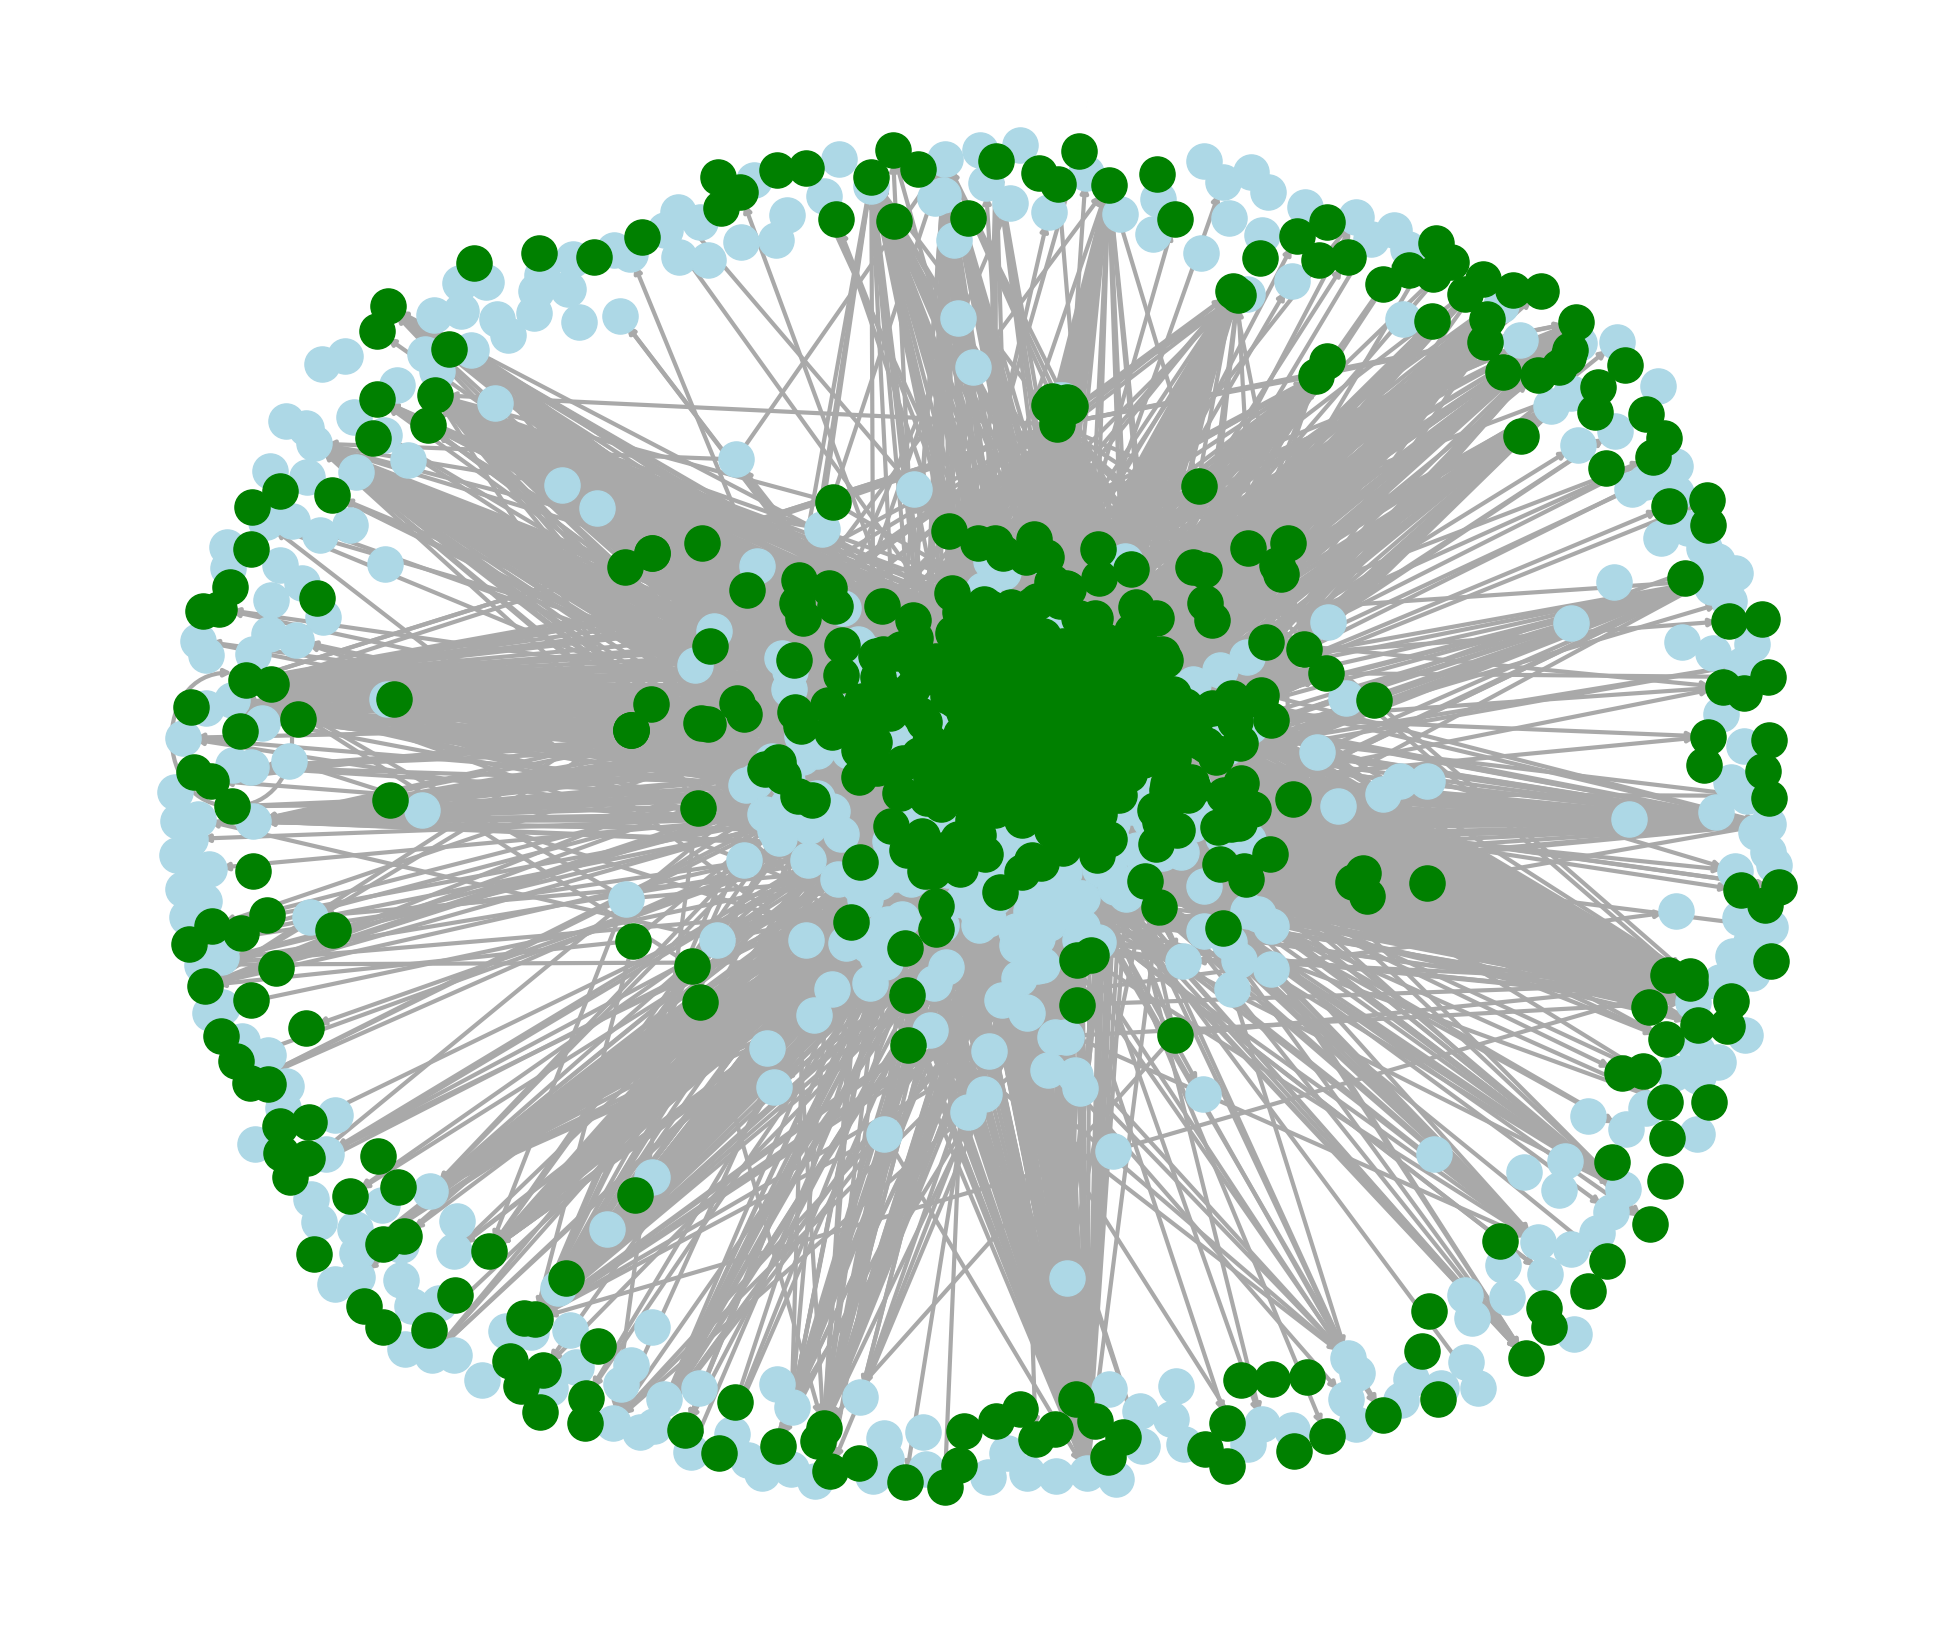

In [ ]:
pos = nx.spring_layout(G1)
plt.figure(figsize=(25,21))
nx.draw_networkx_edges(G1, pos=pos, width=3, edge_color='darkgray')
colors = ['lightblue', 'green']
for community, color in zip(communities_gt, colors):
    nx.draw_networkx_nodes(G1, pos=pos, nodelist=community, node_color=color, node_size=640)
_ = plt.axis('off')
plt.show()

### K-Clique
**Runs out of RAM**

In [ ]:
G1 = G1.to_undirected()
c = list(nx.community.k_clique_communities(G1, 3))
print (len(c))

### Greedy Modularity Maximization (Clauset-Newman-Moore)

In [ ]:
communities_gmm = nx.community.greedy_modularity_communities(G1)
print(f"Communities: {len(communities_gmm)}")

Communities: 280


Plot communitites (too many communitites will not show up clearly!)

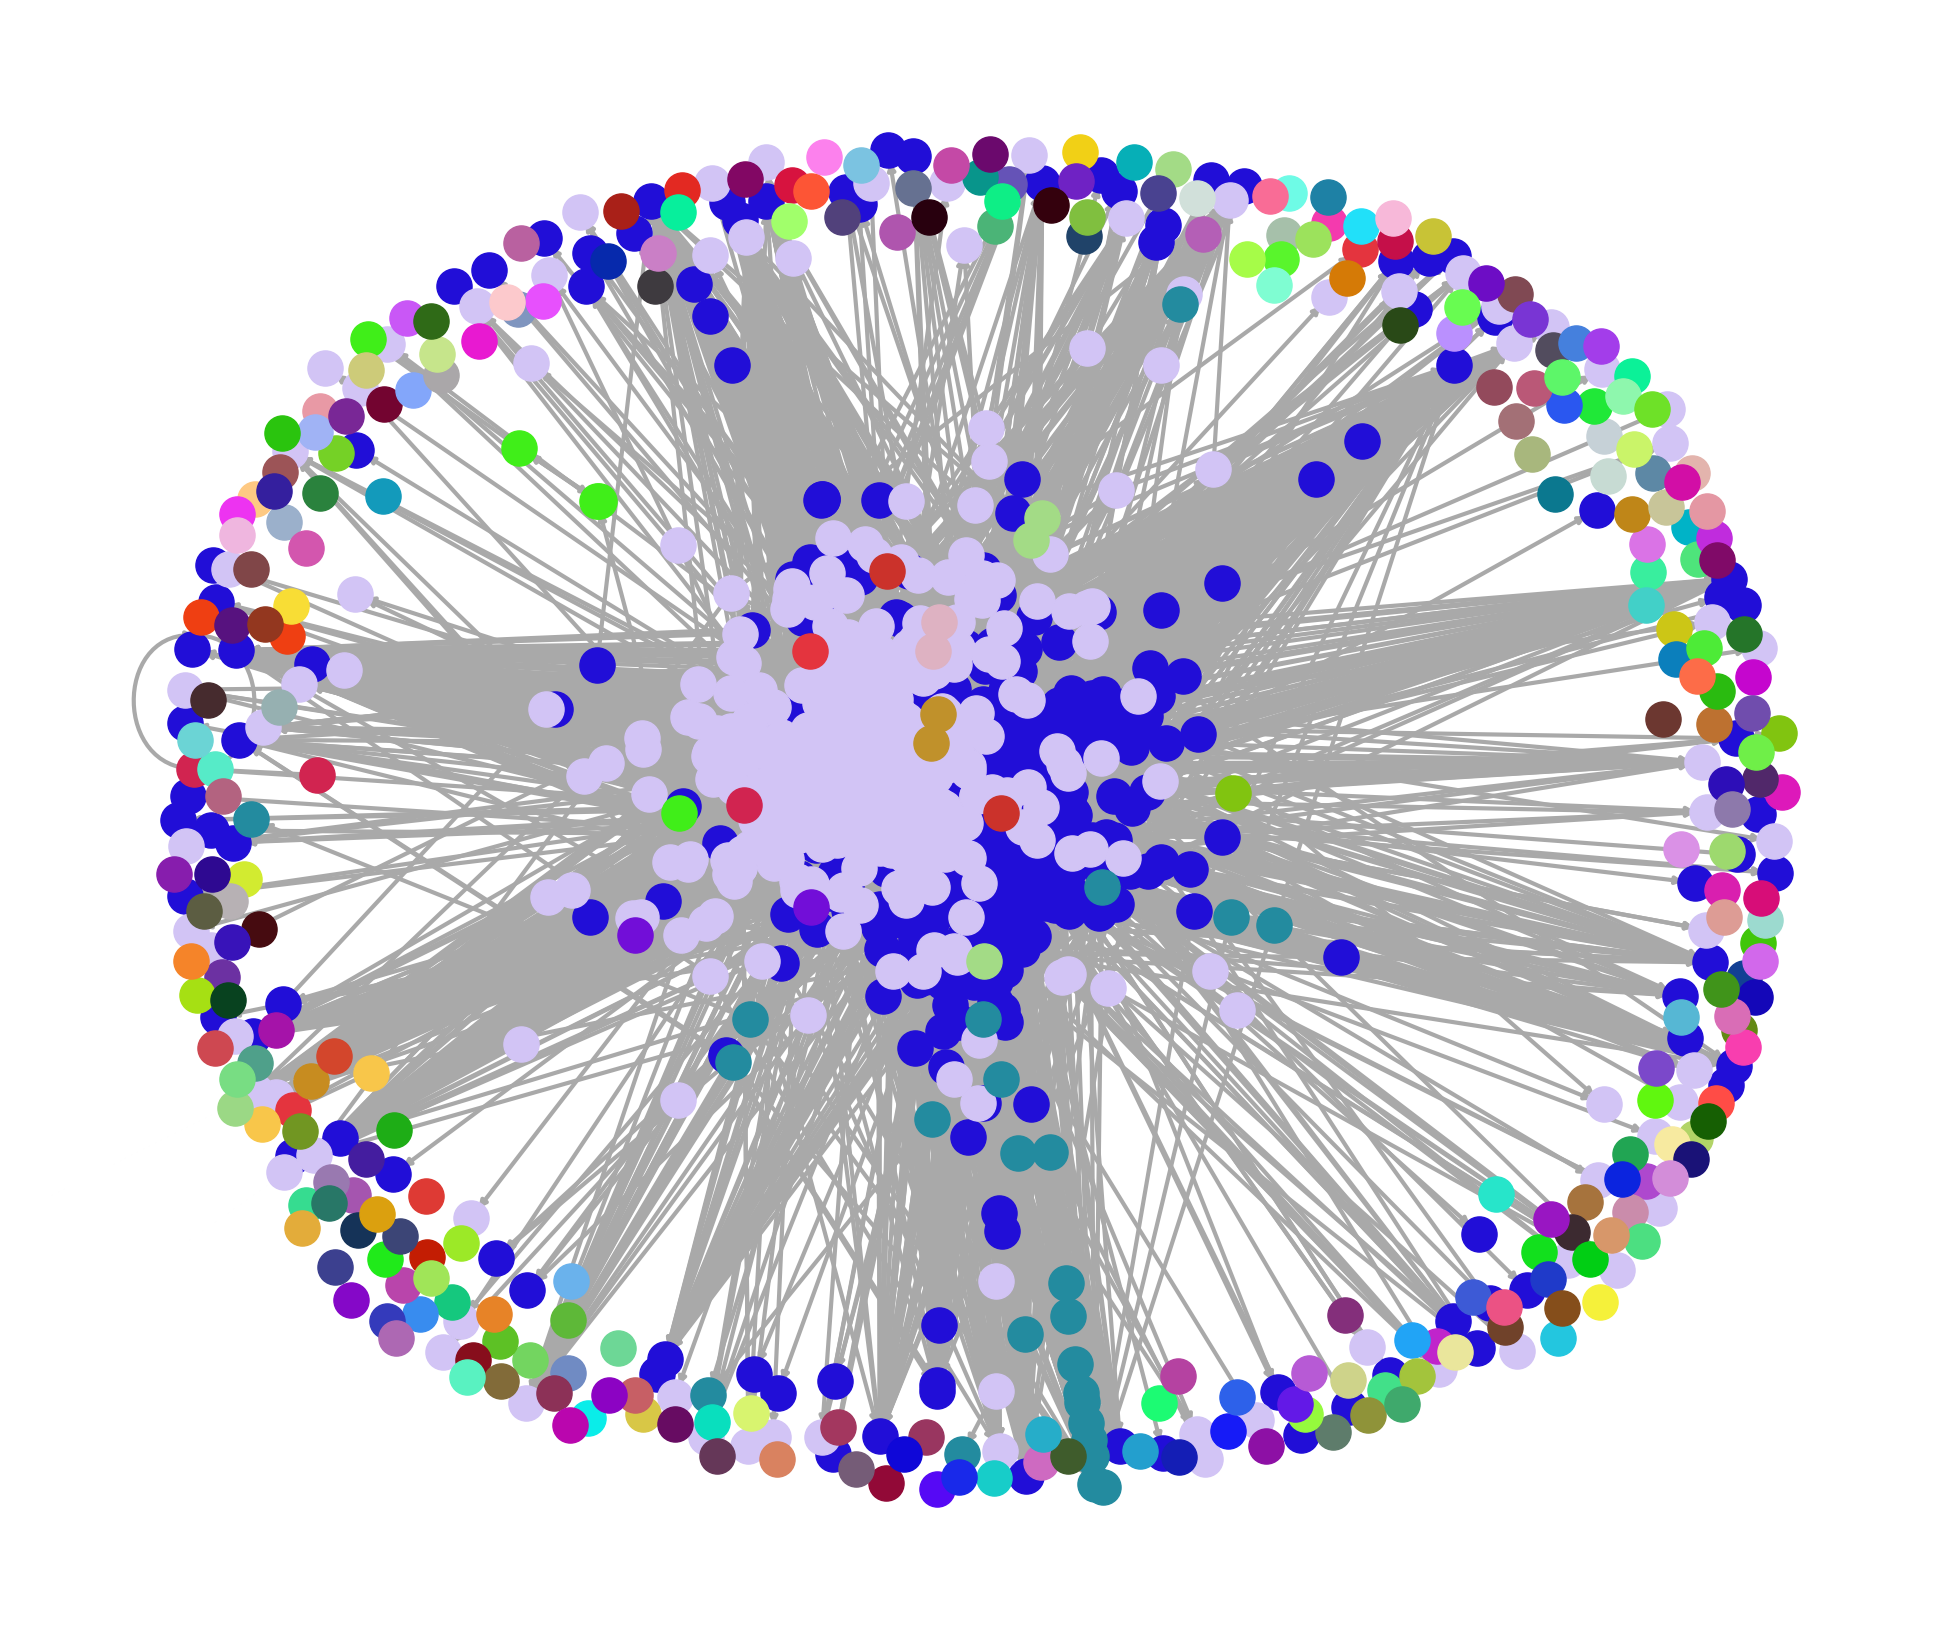

In [ ]:
for i in range(len(communities_gmm)):
    for j in range(len(communities_gmm)):
        if len(communities_gmm[i].intersection(communities_gmm[j])) != 0 and i<j: 
           communities_gmm[i] = communities_gmm[i].difference(communities_gmm[j]) 

pos = nx.spring_layout(G1)
plt.figure(figsize=(25,21))
nx.draw_networkx_edges(G1, pos=pos, width=3, edge_color='darkgray')
colors = ['#%06X' % randint(0, 0xFFFFFF) for _ in range(len(communities_gmm))]
for community, color in zip(communities_gmm, colors):
    nx.draw_networkx_nodes(G1, pos=pos, nodelist=community, node_color=color, node_size=640)
_ = plt.axis('off')
plt.show()

### Divisive Hierarchical Clustering (Girvan-Newman)

In [ ]:
def girvan_newman(G):
    """ run the algorithm of Girvan + Newman up to the first separation
        and return list of components of G, list of edges removed
    """
    
    # we're going to remove edges, so do it on a copy of the original graph
    G = G.copy()
    
    def find_best_edge(G0):
        """ get the edge from G0 with highest betweenness centrality"""
        eb = nx.edge_betweenness_centrality(G0)
        edges = eb.keys()
        return max(edges, key=lambda e: eb[e])

    removed_edges = []
    # Proceed until we separate the graph
    while nx.number_connected_components(G) == 1:
        u, v = find_best_edge(G)
        G.remove_edge(u, v)
        removed_edges.append((u, v))

    return list(nx.connected_components(G)), removed_edges

In [ ]:
G1 = G1.to_undirected()
communities, removed_edges = girvan_newman(G1)
print(f"Communities: {len(communities)}")
other_edges = set(G1.edges()) - set(removed_edges)

Communities: 268


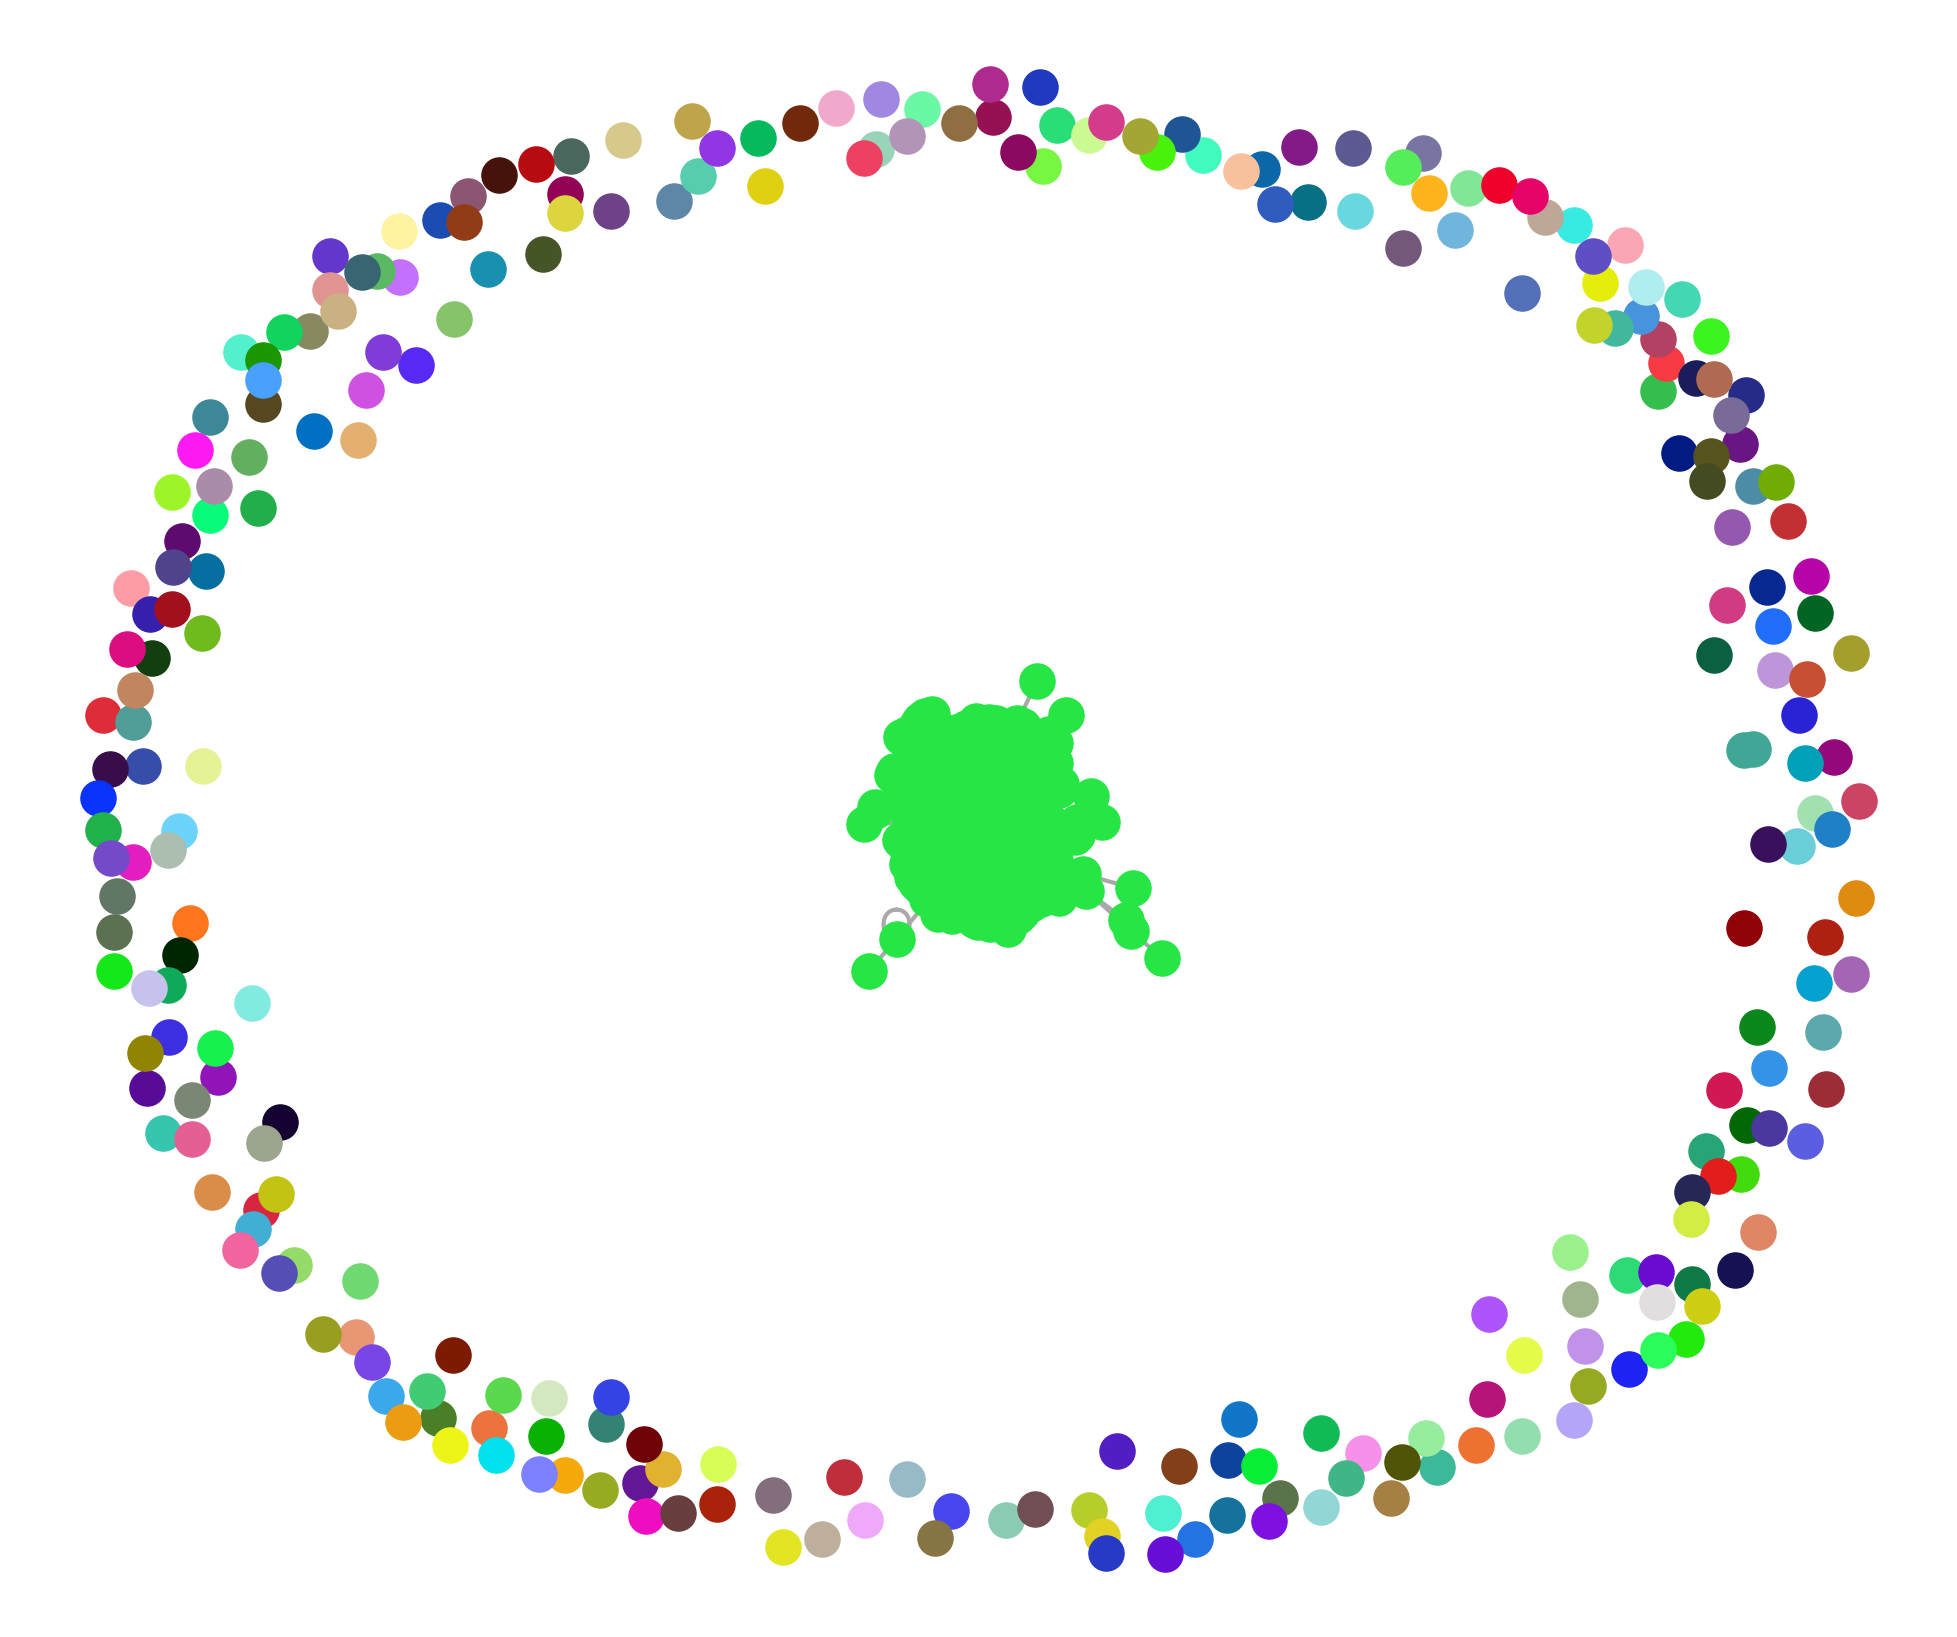

In [ ]:
for i in range(len(communities)):
    for j in range(len(communities)):
        if len(communities[i].intersection(communities[j])) != 0 and i<j: 
           communities[i] = communities[i].difference(communities[j]) 

pos = nx.spring_layout(G1)
plt.figure(figsize=(25,21))
nx.draw_networkx_edges(G1, pos, width=3, edge_color='darkgray', edgelist=other_edges)
nx.draw_networkx_edges(G1, pos, edgelist=removed_edges, style='dotted', edge_color='lightgray', width=5)
colors = ['#%06X' % randint(0, 0xFFFFFF) for _ in range(len(communities))]
for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(G1, pos=pos, nodelist=community, node_color=color, node_size=640)
_ = plt.axis('off')
plt.show()